## Autoencoder

<p align='center'>
  <img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" width=600></img>
</p>

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.

A more detailed illustration is below

<p align='center'>
  <img src='https://miro.medium.com/max/1400/0*_K4yRm8ILDZ02vPq.png' width=600></img>
</p>

The loss function to train such a neural network is the following
$$\mathcal{L}(\theta, \phi) = \frac{1}{n} \sum_{i=1}^n (x_i - f_{\theta}(g_{\phi}(x_i)))^2$$

As seen above, the loss function depends on $\theta$ and $\phi$ which are the parameters that define the encoder and the decoder. From the autoencoder image above, the encoder is represented by $G_{\phi}$, while the decoder is represented by $f_{\theta}$ and they simply mean the weights and bias of the neural network. So in the equation, we are summing up the difference between the original image, $x$, and the reconstructed image $f_{\theta}(g_{\phi}(x'))$.

This is called a `unsupervised` model. It means that there is no `target` or `y` in the model. We only need `x`.

The original paper is [here](https://arxiv.org/abs/1312.6114).




### Setup

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

### Encoder

In [ ]:
# import
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# here we use functional API and recall in our program we introduced sequential API
# sequential API (basic): each dense layer is hard coded layer by layer and you cannot break it apart
# functional API (advanced): each dense layer is soft coded and you can break it apart anywhere in the network model
# ex: x -> f(): f(x) this is a function

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# comment: notice the design, the number of layers is [784, 32, 784]
#          encode layer(s): 784 -> 32 -> 16 -> 2 (this has to decrease)
#          decode layer(s): 2 -> 16 -> 32 -> 784 (this has to increase)
#          otherwise it won't be called autoencoder

# benefit/motivation:
#    (1) the output layer has 784 neurons, which can be rearranged to 28 by 28 which is an image
#    (2) the compressed hidden layer in the middle is called a latent layer, and it is linearly classifiable

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Let's also create a separate encoder model:

In [ ]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

### Decoder

As well as the decoder model:

In [ ]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [ ]:
# configure
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
import tensorflow as tf

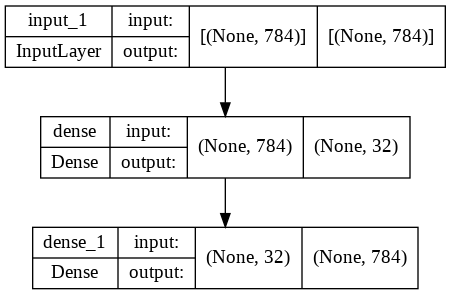

In [ ]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [ ]:
# data
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


### Rescale

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [ ]:
# process and normalize
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Train

```
model.fit(
    x=x_train,
    y=x_train,
    ...
)
```

In [ ]:
# model
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 3s 10ms/step - loss: 0.2808 - val_loss: 0.1921
Epoch 2/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1719 - val_loss: 0.1549
Epoch 3/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1454 - val_loss: 0.1347
Epoch 4/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1293 - val_loss: 0.1219
Epoch 5/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1189 - val_loss: 0.1139
Epoch 6/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1119 - val_loss: 0.1077
Epoch 7/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1068 - val_loss: 0.1034
Epoch 8/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1028 - val_loss: 0.1001
Epoch 9/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0999 - val_loss: 0.0975
Epoch 10/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0979 - val_lo

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

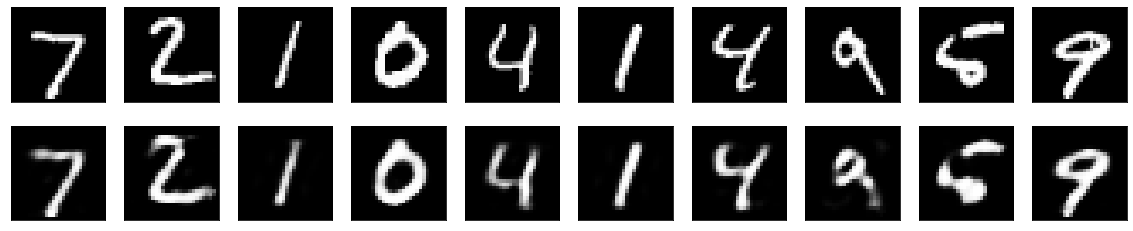

In [ ]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Deep autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [ ]:
model = tf.keras.models.Sequential()
model.add()

In [ ]:
# functional form
output = name_of_function(input_arg)

In [ ]:
# model
input_img = keras.Input(shape=(784,))

# encode
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

# decode
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [ ]:
# build model
autoencoder = keras.Model(input_img, decoded)

In [ ]:
# compile
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# train
autoencoder.fit(x=x_train, y=x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 4s 14ms/step - loss: 0.2522 - val_loss: 0.1726
Epoch 2/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1554 - val_loss: 0.1388
Epoch 3/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1327 - val_loss: 0.1257
Epoch 4/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1231 - val_loss: 0.1180
Epoch 5/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1171 - val_loss: 0.1133
Epoch 6/100
235/235 [==============================] - 3s 14ms/step - loss: 0.1128 - val_loss: 0.1092
Epoch 7/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1089 - val_loss: 0.1062
Epoch 8/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1061 - val_loss: 0.1038
Epoch 9/100
235/235 [==============================] - 3s 12ms/step - loss: 0.1039 - val_loss: 0.1017
Epoch 10/100
235/235 [==============================] - 3s 13ms/step - loss: 0.101

In [ ]:
# predict
decoded_imgs = autoencoder.predict(x_test)
decoded_imgs.shape

(10000, 784)

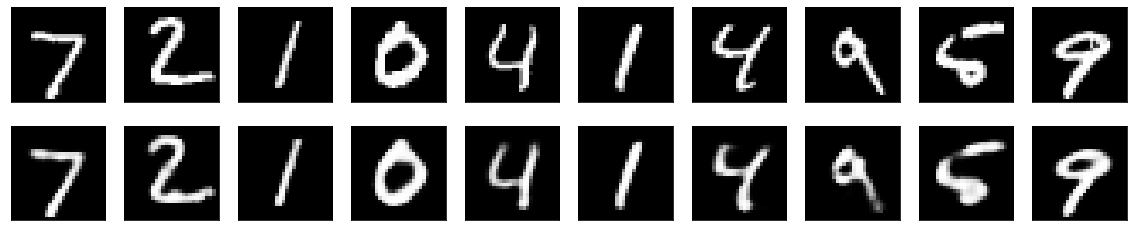

In [ ]:
# Use Matplotlib (don't ask)
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()